In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [66]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [67]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [153]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

class Embedding:
    def __init__(self, vocab_size, dim):
        self.weight = torch.randn((vocab_size, dim))
    def __call__(self, xi):
        self.out = self.weight[xi] 
        return self.out
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [69]:
torch.manual_seed(42);

In [154]:
n_embed = 10
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embed), 
    Flatten(),
    Linear(fan_in=(n_embed * block_size), fan_out=n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
    p.requires_grad = True

parameters: 22097


In [71]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
 

      0/ 200000: 3.3804
  10000/ 200000: 2.0859
  20000/ 200000: 1.9975
  30000/ 200000: 2.0456
  40000/ 200000: 2.0530
  50000/ 200000: 2.0230
  60000/ 200000: 2.3334
  70000/ 200000: 1.9597
  80000/ 200000: 2.2143
  90000/ 200000: 1.9593
 100000/ 200000: 1.5477
 110000/ 200000: 2.2521
 120000/ 200000: 2.3547
 130000/ 200000: 2.2827
 140000/ 200000: 2.1726
 150000/ 200000: 1.9499
 160000/ 200000: 1.5848
 170000/ 200000: 2.2562
 180000/ 200000: 1.8180
 190000/ 200000: 2.0273


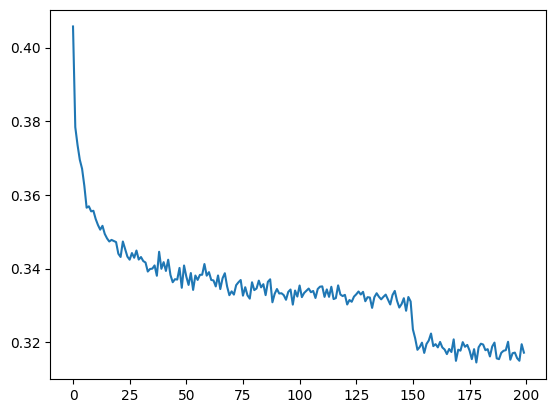

In [56]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [57]:
# Set training to False for evaluation of the model 
for layer in model.layers:
    layer.training = False

In [58]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0584716796875
val 2.1067593097686768


### Let's build a hirarchical model, which processes input of 8 length as 4 bigrams instead of processing the entire 8 characters in one go.


In [73]:
model.layers[0].out.shape, model.layers[0].out[0].shape

(torch.Size([32, 8, 10]), torch.Size([8, 10]))

The embedding shape and size will remain the same. 

The earlier case, each input embedding was flattened into [1, 80] and then fed to the hidden layer. 
<br/>But now, we want to process each input as a sequence of bigrams. That means, for each input we will have 4 bigrams. For a batch size of 32 inputs, we will have 4 bigrams each, and the length of each bigram embedding will be 20. Over all, for a batch size of 32, the shape after flattening should be, [32, 4, 20], as opposed to [32, 80].

<br/> Let's update  our flattening layer in order to achieve that.

In [74]:
x = model.layers[0].out

In [75]:
x.shape

torch.Size([32, 8, 10])

In [78]:
A, B, C = x.shape
# A is the batch size
# B is the block size
# C is the dimensions of the embedding

In [79]:
x.view(A, -1, 2 * C).shape

torch.Size([32, 4, 20])

In [80]:
x.view(A, B // 2, 2 * C).shape

torch.Size([32, 4, 20])

In [94]:
class Flatten:
    def __init__(self, n): # n is the number of characters we want to process together (2 in our example)
        self.n = n
    def __call__(self, x):
        A, B, C = x.shape
        y = x.view(A, B // self.n, self.n * C)
        
        if y.shape[1] == 1:
            y = y.squeeze(1)
        self.out = y 
        return self.out
        return self.out
    def parameters(self):
        return []

In [95]:
x = torch.randn((32, 8, 10))
x.shape
f = Flatten(2)
f(x).shape

torch.Size([32, 4, 20])

In [96]:
### Test if the middle dimension is 1, it should squeeze
f = Flatten(8)
f(x).squeeze(1).shape

torch.Size([32, 80])

In [102]:
model.layers[2].out.shape

torch.Size([32, 200])

In [104]:
x = torch.randn((32, 8, 10))
f = Flatten(2)
x = f(x)
l = Linear(20, 200)
l(x).shape

torch.Size([32, 4, 200])

### Now that the flattening dimensions have changed, the linear layer parameters will also change. Since each input is of 20 dimensions now, the fan in of the linear layer will change. But before we reinitialise the model parameters, let's look at the BatchNorm1d layer first. 

The BatchNorm computes the mean and std for a neuron over all the inputs in a batch. Earlier, the batch size was 32. But now, if you think about it, since we will be processing 4 bigrams parallelly. 4 is also kind of a batch size as well. Hence, we have 32 * 4 batch size over which the mean and std should be computed. 

In [107]:
o = l(x)
o.shape

torch.Size([32, 4, 200])

This will be the input to BatchNorm1d now. It has to compute mean and std not only over dimension 0, but over dimensions 0 and 1.

In [108]:
mean = o.mean((0, 1), keepdim=True)
mean.shape

torch.Size([1, 1, 200])

I am updating the BatchNorm1d class above, since the class is big. 
### Let's redefine the model now. And we will add some more hidden layers this time around. 

In [181]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [185]:
n_embd = 25 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
    p.requires_grad = True

parameters: 177302


In [186]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.4416
  10000/ 200000: 2.5984
  20000/ 200000: 2.1030
  30000/ 200000: 2.5754
  40000/ 200000: 1.8996
  50000/ 200000: 1.9882
  60000/ 200000: 2.1924
  70000/ 200000: 2.1983
  80000/ 200000: 2.3228
  90000/ 200000: 1.5886
 100000/ 200000: 2.2662
 110000/ 200000: 2.0661
 120000/ 200000: 1.7717
 130000/ 200000: 1.8776
 140000/ 200000: 1.8387
 150000/ 200000: 1.7149
 160000/ 200000: 1.7419
 170000/ 200000: 1.7760
 180000/ 200000: 1.6847
 190000/ 200000: 1.8351


In [187]:
for layer in model.layers:
    layer.training = False

split_loss('train')
split_loss('val')

train 1.7000768184661865
val 1.9976288080215454


In [210]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

rosaalee.
marah.
kamaleya.
jitheya.
laylah.
grey.
rahman.
mehra.
keelen.
karmyan.
maita.
tahloni.
keyon.
aette.
jodi.
eumekgaidra.
jennette.
gianelli.
gasselynn.
gracely.


In [218]:
logits = model(Xtr[[7]])

In [306]:
class Conv1d:
    def __init__(self, sequence_length, in_channels, out_channels, kernel=2, stride=1):
        self. sequence_length = sequence_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride 
        self.filters = torch.randn((out_channels, in_channels, kernel))
    def __call__(self, x):
        N, L, C = x.shape
        # create the sliding windows of the input 
        x_unfolded = x.unfold(1, self.kernel, self.stride)

        Lout = ((self.sequence_length - self.kernel) // self.stride) + 1

        # Before cross correlation, we need to broadcast the filters and the input correctly
        x_unfolded = x_unfolded.view(N, 1, Lout, C, self.kernel)
        self.filters = self.filters.view(1, self.out_channels, 1, self.in_channels, self.kernel)

        # Perform element wise multiplication
        self.out = torch.mul(x_unfolded, self.filters).sum((3, 4))
        return self.out        
            

In [359]:
x = torch.randn((32, 10, 8))
x_unfolded = x.unfold(2, 2, 1)
x_unfolded.shape


torch.Size([32, 10, 7, 2])

In [360]:
filters = torch.randn((20, 10, 2))
filters.shape

torch.Size([20, 10, 2])

In [361]:
x_unfolded = x_unfolded.view(32, 1, 10, 7, 2)
x_unfolded.shape

torch.Size([32, 1, 10, 7, 2])

In [362]:
filters = filters.view(1, 20, 10, 1, 2)
filters.shape

torch.Size([1, 20, 10, 1, 2])

In [363]:
mul_res = torch.mul(x_unfolded, filters)
mul_res.shape

torch.Size([32, 20, 10, 7, 2])

In [364]:
mul_res.sum(dim=(2, 4)).shape

torch.Size([32, 20, 7])

In [403]:
bias = torch.randn(20)

In [405]:
out = mul_res.sum(dim=(2, 4)) + bias.view(1, 20, 1)
out.shape

torch.Size([32, 20, 7])

In [305]:
x = torch.randn((32, 8, 10))
conv1d = Conv1d(8, 10, 20)
conv1d(x).shape

torch.Size([32, 20, 7])

In [528]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX].transpose(1, 2)
    
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# --------------------------------------------
class Conv1d:
    def __init__(self, sequence_length, in_channels, out_channels, kernel=2, stride=1):
        self. sequence_length = sequence_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride 
        self.filters = torch.randn((out_channels, in_channels, kernel)) * 0.1
        self.bias = torch.randn(out_channels) * 0
    def __call__(self, x):
        N, C, L = x.shape
        # create the sliding windows of the input 
        x_unfolded = x.unfold(2, self.kernel, self.stride)

        Lout = ((self.sequence_length - self.kernel) // self.stride) + 1

        # Before cross correlation, we need to broadcast the filters and the input correctly
        x_unfolded = x_unfolded.view(N, 1, C, Lout, self.kernel)
        filters = self.filters.view(1, self.out_channels, self.in_channels, 1, self.kernel)

        # Perform element wise multiplication
        self.out = torch.mul(x_unfolded, filters).sum((2, 4)) + self.bias.view(1, self.out_channels, 1)
        return self.out        
    
    def parameters(self): 
        return [self.filters]

class ReLu: 
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out

    def parameters(self):
        return []
        
class Transpose:
    def __call__(self, x):
        self.out = x.transpose(1, 2)
        return self.out
    
    def parameters(self):
        return []

In [531]:
### Let's redefine the model with conv layers 
n_embedding = 10

# conv1d_1
n_conv1_out_channels = 20
n_conv1_stride = 1 
n_conv1_kernel = 2
conv1_L_out = ((block_size - n_conv1_kernel) // n_conv1_stride) + 1

# conv1d_2
n_conv2_out_channels = 30
n_conv2_stride = 1 
n_conv2_kernel = 3
conv2_L_out = ((conv1_L_out - n_conv2_kernel) // n_conv2_stride) + 1

# conv1d_3
n_conv3_out_channels = 40
n_conv3_stride = 1 
n_conv3_kernel = 4
conv3_L_out = ((conv2_L_out - n_conv3_kernel) // n_conv3_stride) + 1

# Hirarchical layer 1
h1_fanout = 100 
h1_stride = 2
# Hirarchical layer 2



model = Sequential([
    Embedding(vocab_size, n_embedding), 
    Conv1d(sequence_length=block_size, in_channels=n_embedding, out_channels=n_conv1_out_channels, kernel=n_conv1_kernel, stride=n_conv1_stride), ReLu(),
    Conv1d(sequence_length=conv1_L_out, in_channels=n_conv1_out_channels, out_channels=n_conv2_out_channels, kernel=n_conv2_kernel, stride=n_conv2_stride), ReLu(),
    Conv1d(sequence_length=conv2_L_out, in_channels=n_conv2_out_channels, out_channels=n_conv3_out_channels, kernel=n_conv3_kernel, stride=n_conv3_stride), ReLu(),
    Transpose(), Linear(fan_in=n_conv3_out_channels, fan_out=h1_fanout), Tanh(),
    FlattenConsecutive(2), Linear(fan_in=h1_fanout * h1_stride, fan_out=h1_fanout), Tanh(),
    Linear(fan_in=h1_fanout, fan_out=vocab_size)
])



with torch.no_grad():
    model.layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
    p.requires_grad = True

parameters: 34197


In [540]:
# same optimization as last time
max_steps = 50_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01 if i < 100000 else 0.01 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/  50000: 2.0213
  10000/  50000: 1.8745
  20000/  50000: 1.5550
  30000/  50000: 1.9221
  40000/  50000: 1.9562


In [537]:
for layer in model.layers:
    layer.training = False

split_loss('train')
split_loss('val')

train 1.8932315111160278
val 2.0289735794067383


### Performance log 
#### with 40 filter size of each conv layer, 10 dimensional embedding
* train 1.9566978216171265
* val 2.0483827590942383

#### With 20, 30, 40 filters (increasing by 10 at each layer), 10 dimensional embedding
* train 1.911450743675232
* val 2.0312490463256836
#### Trained the above for another 50k epochs with 0.01 learning rate
* train 1.8932315111160278
* val 2.0289735794067383

In [538]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

fakirah.
braccon.
kayslee.
korlyn.
maziah.
kohap.
lylia.
cirio.
keatzeoty.
kaeda.
adrii.
kanav.
fiobbathir.
cai.
deaken.
paxton.
braydan.
aaniylah.
aurionne.
kinsley.


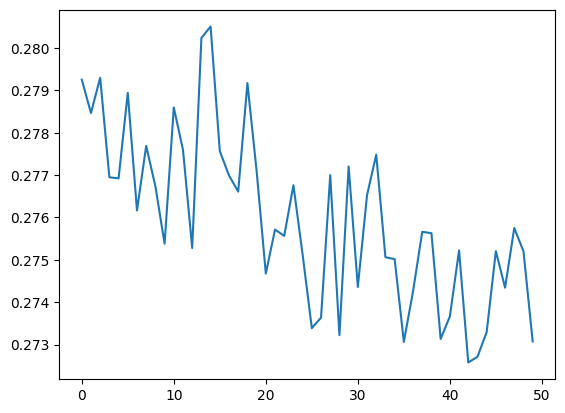

In [539]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [542]:
model.layers[1].out.shape

torch.Size([32, 20, 7])